<div style="display: flex; 
            background-image: url('http://storage.googleapis.com/kaggle-media/competitions/Santa/eric-prouzet-CYwMB07Eguk-unsplash.jpg');">
    <div style="display: flex; width: 100%; color:white; background-color:rgba(100, 15, 15, 0.5); text-align: center">
        <h1 style="width: 100%; padding: 50px;"> <span style="color:white">The Christmas Card Conundrum 2022</span> </h1>
    </div>
</div>


__Problem Description:__


The job is <span style="color:orange">**to determine the most optimal way to craft this year’s Christmas card**</span>, by selecting the <span style="color:green">**most efficient path of both moving the robotic arm and changing the print color to craft this year’s image**</span>. Each link of the printer arm can be moved independently each step, but you'll also need to account for the time needed to change the printing color.

**Considerations:**

- 8-axis robotic arm print one pixel of the card at a time
- It is neccesariy to spend the least amount of cost possible making the card, minimizing <span style="color:gold">**Reconfiguration Cost** and **Color Change Cost**</span>.

This can be solve as a **TPS optimization problem**.

# <p style="font-family:Helvetica; font-weight:bold; letter-spacing: 0px; color:#cc1818; font-size:100%; text-align:left;padding: 5px; border-bottom: 5px solid #cc1818">Import Libraries</p>

In [448]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# <p style="font-family:Helvetica; font-weight:bold; letter-spacing: 0px; color:#cc1818; font-size:100%; text-align:left;padding: 5px; border-bottom: 5px solid #cc1818">Proposed Solution</p>

The problem can be divided in two:

- Set contraints to the arm configurations space.
- Find a solution in color space with these constrains

## Set contraints to the arm configurations space
There is a <span style='color:orange'>robotic arm with eight links</span> with lengths $[64,32,16,8,4,2,1,1]$, this arm must "print" each point of the 257x257 image.

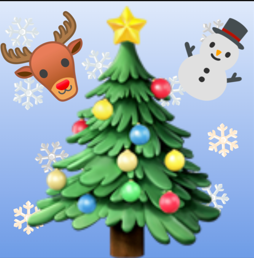

The configuration of the arm is described by a list of displacement vectors, like:

$[(x_{1},y_{1}),(x_{2},y_{2}),(x_{3},y_{3}),(x_{4},y_{4}),(x_{5},y_{5}),(x_{6},y_{6}),(x_{7},y_{7}),(x_{8},y_{8})]$ where a vector $(x_i,y_i)$ of length $l_i$ must satisfy  $max(|x_i|,|y_i|)=l_i$. 

This condition means that at least one of the components of the vector must be equal to plus-or-minus the length of the vector. But also, implies a non-Eclidean space problem since the Ecludian length of vectors change to satisfy this condition.

E.g.:

Displacement vector: $[(64,4),(32,4),(16,8),(8,4),(4,2),(2,2),(1,1),(1,1)] == (64,72)$ final pixel.


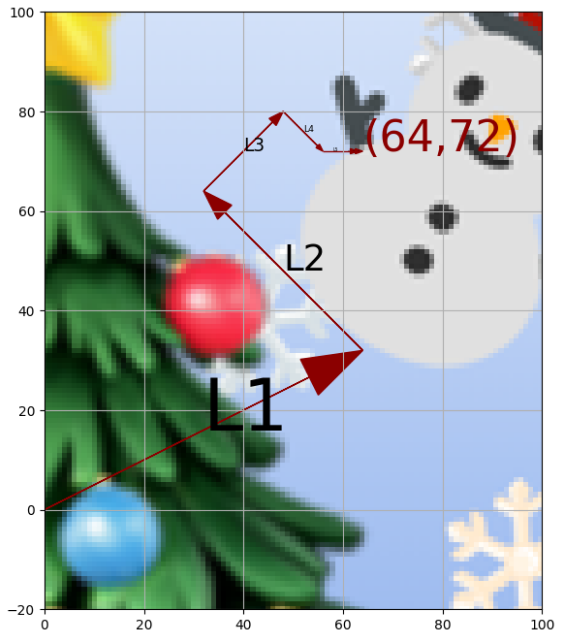

As you can expect, there are equivalent arm configurations that end up in the same pixel, but there is a differente cost for them. In total there are ~$4.8 x 10^{11}$ possible arm configurations, <span style='color:orange'>which is the most cost-efficient sequence?</span>.

The user AMBROSM states [here](https://www.kaggle.com/competitions/santa-2022/discussion/376306) that is possible to reduce the arm configuration search. **"The robot has been constrained so that the first (longest) arm always points to the right side and the other seven arms always point upwards."**. In such a way that is possible to match each (x,y) point to a certain arm configuration for the top-right quarter of the image, and even the others the configurations are rotated in multiples of 90 degress.

For each quadrant of the image a certain arm configuration form is obtained:
<pre>
- Top right quarter:     [( 64,   ), (   , 32), (  ,  16), (   , 8 ), (   ,  4), (   ,  2), (   ,  1), (   ,  1)]
- Bottom right quarter:  [(   ,-64), ( 32,   ), ( 16,   ), (  8,   ), (  4,   ), (  2,   ), (  1,   ), (  1,   )]
- Top left quarter:      [(   , 64), (-32,   ), (-16,   ), ( -8,   ), ( -4,   ), ( -2,   ), ( -1,   ), ( -1,   )]
- Bottom left quarter:   [(-64,   ), (   ,-32), (   ,-16), (   ,-8 ), (   , -4), (   , -2), (   , -1), (   , -1)]
</pre>
This is a 8-dimension problem that can be reduced with this constrain.
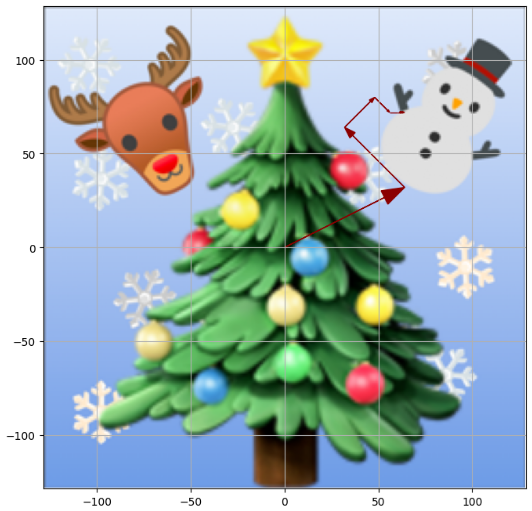

In [452]:
def standard_config_topright(x, y):
    """Return the preferred configuration (list of eight pairs) for the point (x,y)"""
    assert x > 0 and y >= 0, "This function is only for the upper right quadrant"
    r = 64
    config = [(r, y-r)] # longest arm points to the right
    x = x - config[0][0]
    while r > 1:
        r = r // 2
        arm_x = np.clip(x, -r, r)
        config.append((arm_x, r)) # arm points upwards
        x -= arm_x
    arm_x = np.clip(x, -r, r)
    config.append((arm_x, r)) # arm points upwards
    assert x == arm_x
    return config

def prefer_config(x,y):
    #assert ~(x==0 and y==0), "Do not consider origin (0,0)" 
    
    if x>0 and y >= 0: # top right quadrant
        return standard_config_topright(x, y)
    
    if x>=0 and y<0: # bottom right quadrant
        rotated_config = standard_config_topright(-y, x)
        return [(y, -x) for (x, y) in rotated_config]
    
    if x<=0 and y>0: # top left quadrant
        rotated_config = standard_config_topright(y, -x)
        return [(-y, x) for (x, y) in rotated_config]
    
    if x<0 and y<=0: # bottom left quadrant
        rotated_config = standard_config_topright(-x, -y)
        return [(-x,-y) for (x,y) in rotated_config]
    
    return None #"Do not considered origin (0,0)"

In [453]:
def df_to_image(df):
    side = int(len(df) ** 0.5)  # assumes a square image
    df1 = df.set_index(['x', 'y']).to_numpy().reshape(side, side, -1)
    return np.array(df1, dtype='float32')

In [454]:
df_image = pd.read_csv('/kaggle/input/santa-2022/image.csv')
image = df_to_image(df_image)

In [455]:
df_q1 = df_image[(df_image['x']>=1) & (df_image['y']>=0)].reset_index(drop=True)

df_q2 = (df_image[(df_image['x']>=0) & (df_image['y']<=-1)]
         .sort_values(by=['y','x'], ascending=[0,0])
         .reset_index(drop=True))

df_q3 = df_image[(df_image['x']<=-1) & (df_image['y']<=0)].iloc[::-1].reset_index(drop=True)

# ignore section x=0, y>0
df_q4 = (df_image[(df_image['x']<=-1) & (df_image['y']>=1)]
         .sort_values(by=['y','x'], ascending=[1,1])
         .reset_index(drop=True))

In [456]:
### Auxiliar Dictionaries

df_q1_dict = {(el[0], el[1]):cnt for cnt,el in enumerate(df_q1[['x','y']].values)}
df_q2_dict = {(el[0], el[1]):cnt for cnt,el in enumerate(df_q2[['x','y']].values)}
df_q3_dict = {(el[0], el[1]):cnt for cnt,el in enumerate(df_q3[['x','y']].values)}
df_q4_dict = {(el[0], el[1]):cnt for cnt,el in enumerate(df_q4[['x','y']].values)}

df_q1_dict_rev = {v: k for k, v in df_q1_dict.items()}
df_q2_dict_rev = {v: k for k, v in df_q2_dict.items()}
df_q3_dict_rev = {v: k for k, v in df_q3_dict.items()}
df_q4_dict_rev = {v: k for k, v in df_q4_dict.items()}

# <p style="font-family:Helvetica; font-weight:bold; letter-spacing: 0px; color:#cc1818; font-size:100%; text-align:left;padding: 5px; border-bottom: 5px solid #cc1818">LKH Implementation</p>

As stated [here](http://webhotel4.ruc.dk/~keld/research/LKH/), LKH is an effective implementation of the  <span style="color:orange">**Lin-Kernighan heuristic for solving the traveling salesman problem** </span>.

In [8]:
%%bash -e
wget http://akira.ruc.dk/~keld/research/LKH-3/LKH-3.0.8.tgz
tar xvfz LKH-3.0.8.tgz

cd LKH-3.0.8
make

--2023-09-26 14:49:17--  http://akira.ruc.dk/~keld/research/LKH-3/LKH-3.0.8.tgz
Resolving akira.ruc.dk (akira.ruc.dk)... 130.225.220.230
Connecting to akira.ruc.dk (akira.ruc.dk)|130.225.220.230|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2318525 (2.2M) [application/x-gzip]
Saving to: ‘LKH-3.0.8.tgz’

     0K .......... .......... .......... .......... ..........  2% 1.62M 1s
    50K .......... .......... .......... .......... ..........  4% 2.48M 1s
   100K .......... .......... .......... .......... ..........  6% 4.34M 1s
   150K .......... .......... .......... .......... ..........  8% 6.76M 1s
   200K .......... .......... .......... .......... .......... 11% 7.01M 1s
   250K .......... .......... .......... .......... .......... 13% 14.1M 1s
   300K .......... .......... .......... .......... .......... 15% 13.1M 0s
   350K .......... .......... .......... .......... .......... 17% 25.7M 0s
   400K .......... .......... .......... .......... ........

LKH-3.0.8/
LKH-3.0.8/pr2392.par
LKH-3.0.8/whizzkids96.atsp
LKH-3.0.8/Makefile
LKH-3.0.8/whizzkids96.par
LKH-3.0.8/pr2392.tsp
LKH-3.0.8/DOC/
LKH-3.0.8/README.txt
LKH-3.0.8/SRC/
LKH-3.0.8/SRC/Penalty_CVRPTW.c
LKH-3.0.8/SRC/RestoreTour.c
LKH-3.0.8/SRC/SolveKMeansSubproblems.c
LKH-3.0.8/SRC/IsCommonEdge.c
LKH-3.0.8/SRC/Penalty_TSPPD.c
LKH-3.0.8/SRC/ReadProblem.c
LKH-3.0.8/SRC/BestKOptMove.c
LKH-3.0.8/SRC/Distance_SPECIAL.c
LKH-3.0.8/SRC/Penalty_TSPDL.c
LKH-3.0.8/SRC/Penalty_PDPTW.c
LKH-3.0.8/SRC/Penalty_ACVRP.c
LKH-3.0.8/SRC/CreateCandidateSet.c
LKH-3.0.8/SRC/OBJ/
LKH-3.0.8/SRC/Forbidden.c
LKH-3.0.8/SRC/Penalty_CCVRP.c
LKH-3.0.8/SRC/Penalty_M_PDTSP.c
LKH-3.0.8/SRC/Best5OptMove.c
LKH-3.0.8/SRC/RecordBetterTour.c
LKH-3.0.8/SRC/Best4OptMove.c
LKH-3.0.8/SRC/Exclude.c
LKH-3.0.8/SRC/C.c
LKH-3.0.8/SRC/IsCandidate.c
LKH-3.0.8/SRC/Make3OptMove.c
LKH-3.0.8/SRC/Make2OptMove.c
LKH-3.0.8/SRC/ResetCandidateSet.c
LKH-3.0.8/SRC/LKHmain.c
LKH-3.0.8/SRC/SolveSFCSubproblems.c
LKH-3.0.8/SRC/ERXT.c
LKH-3.0.8/S

ReadEdges.c: In function ‘ReadEdges’:
ReadEdges.c:31:9: warning: ignoring return value of ‘fscanf’, declared with attribute warn_unused_result [-Wunused-result]
   31 |         fscanf(EdgeFile, "%d %d\n", &i, &Edges);
      |         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ReadEdges.c:36:13: warning: ignoring return value of ‘fgets’, declared with attribute warn_unused_result [-Wunused-result]
   36 |             fgets(line, 80, EdgeFile);
      |             ^~~~~~~~~~~~~~~~~~~~~~~~~


cc -c -o OBJ/ReadLine.o ReadLine.c -O3 -Wall -IINCLUDE -DTWO_LEVEL_TREE -g -fcommon
cc -c -o OBJ/ReadParameters.o ReadParameters.c -O3 -Wall -IINCLUDE -DTWO_LEVEL_TREE -g -fcommon
cc -c -o OBJ/ReadPenalties.o ReadPenalties.c -O3 -Wall -IINCLUDE -DTWO_LEVEL_TREE -g -fcommon
cc -c -o OBJ/ReadProblem.o ReadProblem.c -O3 -Wall -IINCLUDE -DTWO_LEVEL_TREE -g -fcommon


ReadProblem.c: In function ‘Read_EDGE_DATA_SECTION’:
ReadProblem.c:1209:21: warning: ignoring return value of ‘fscanf’, declared with attribute warn_unused_result [-Wunused-result]
 1209 |                     fscanf(ProblemFile, "%lf", &w);
      |                     ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


cc -c -o OBJ/RecordBestTour.o RecordBestTour.c -O3 -Wall -IINCLUDE -DTWO_LEVEL_TREE -g -fcommon
cc -c -o OBJ/RecordBetterTour.o RecordBetterTour.c -O3 -Wall -IINCLUDE -DTWO_LEVEL_TREE -g -fcommon
cc -c -o OBJ/RemoveFirstActive.o RemoveFirstActive.c -O3 -Wall -IINCLUDE -DTWO_LEVEL_TREE -g -fcommon
cc -c -o OBJ/ResetCandidateSet.o ResetCandidateSet.c -O3 -Wall -IINCLUDE -DTWO_LEVEL_TREE -g -fcommon
cc -c -o OBJ/RestoreTour.o RestoreTour.c -O3 -Wall -IINCLUDE -DTWO_LEVEL_TREE -g -fcommon
cc -c -o OBJ/SegmentSize.o SegmentSize.c -O3 -Wall -IINCLUDE -DTWO_LEVEL_TREE -g -fcommon
cc -c -o OBJ/Sequence.o Sequence.c -O3 -Wall -IINCLUDE -DTWO_LEVEL_TREE -g -fcommon
cc -c -o OBJ/SFCTour.o SFCTour.c -O3 -Wall -IINCLUDE -DTWO_LEVEL_TREE -g -fcommon
cc -c -o OBJ/SolveCompressedSubproblem.o SolveCompressedSubproblem.c -O3 -Wall -IINCLUDE -DTWO_LEVEL_TREE -g -fcommon
cc -c -o OBJ/SINTEF_WriteSolution.o SINTEF_WriteSolution.c -O3 -Wall -IINCLUDE -DTWO_LEVEL_TREE -g -fcommon
cc -c -o OBJ/SOP_RepairTour.

To use the LKH provided software, predefined cost functions can be used as cost funcitons such as Euclidean or Manhattan distance. However in this case the predifined cost has this form:

$$Cost\ Function\ per\ Step  = \sqrt{\#\ \mathrm{links\ changed}} + 3.0 * abs\ (\mathrm{color\ difference})$$

 - There is no conflict with **color cost** calculations between pixels directly, but in the case of **reconfiguration cost**, it depends on the configurations of the robotic arm where it came from and where it needs to go. 

- Due to the predefined constrains, it is possible to obtain all configurations of the robotic arm within a given quadrant of the image. With this, it is possible to calculate all the pixel changes that can be achieved in a single pass of the robotic arm, and then calculate how many links need to be changed per pixel.

In [458]:
################  Defined cost function for the TPS problem 

from functools import reduce

def check_integrity_config(config1, config2):
    t1 = np.array(config1)
    t2 = np.array(config2)
    return np.max(np.abs(t1 - t2), axis=1).max()

def cost_file(from_position, to_position, image):
    if from_position == to_position: return 0
    
    x1 = 128+from_position[0] ; y1 = 128-from_position[1]
    x2 = 128+to_position[0] ;   y2 = 128-to_position[1]
    
    scale_factor = 3 # color cost
    precision = 100
    
    dx = abs(x1-x2)
    dy = abs(y1-y2)
    
    if dx>3 or dy>3:
        return 14 * precision# high cost
    else:
        from_config = prefer_config(x=from_position[0], y=from_position[1])
        to_config   = prefer_config(x=to_position[0],   y=to_position[1])
        
        if check_integrity_config(from_config, to_config)==1:
            r = np.abs(image[(y2,x2)] - image[(y1,x1)]).sum() * scale_factor
            # allow to go one or two two pixels horizontally at one step
            #dx = 1 if (dx==2 and dy==0) else dx
            
            #diff = max(dx, dy)
            #extra =  dx*0.414 if dx==dy else 0 # sqrt(2)-1 at ~extra cost to move a step at diagonal
            #diff = np.sqrt(dx+dy)
            diff = np.sqrt(dx+dy)
            return int((r+diff) * precision) #int((r+(diff-1+extra))*10000) 
        else:
            return 14 * precision


Text(0.5, 0.98, 'Point (5,64)')

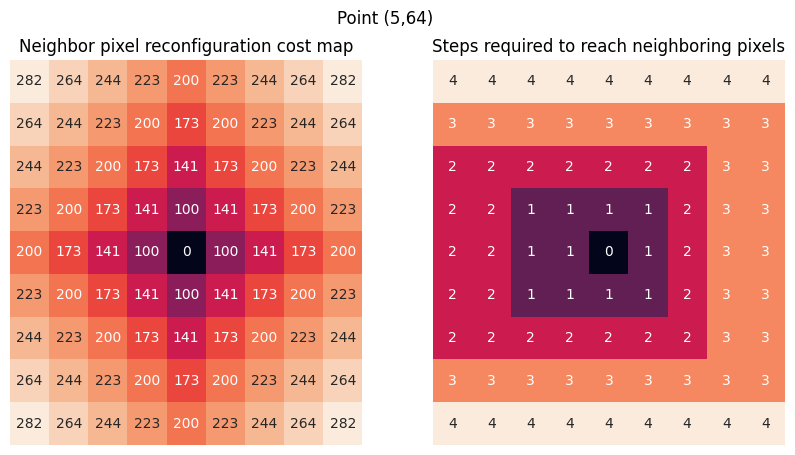

In [473]:
def quadrant(x,y):
    if x==0 and y==0:
        return 0
    if x>0 and y>=0:
        return 1
    elif x>=0 and y<0:
        return 2
    elif x<0 and y<=0:
        return 3
    elif y>0 and x<=0:
        return 4

def map_config_difff(point, radius, ax):
    x0,y0 = point #(5,64)
    if point==(0,0):
        return np.zeros(shape=(radius*2+1,radius*2+1))  #ignore center point
    
    q0 = quadrant(x0,y0)
    config_base = prefer_config(x=x0,y=y0)
    
    #radius = 4
    r = np.zeros(shape=(radius*2+1,radius*2+1))
    for x in range(-radius,radius+1):
        for y in range(-radius,radius+1):
            if abs(x0+x)<129 and abs(y0+y)<129:
                q1 = quadrant(x0+x,y0+y)
                if q0==q1:
                    r[radius-y,radius-x] = check_integrity_config(prefer_config(x0,y0), prefer_config(x0+x, y0+y))
    
    #f,ax=plt.subplots(figsize=(3,3))
    sns.heatmap(r, annot=True, cbar=False, ax=ax)
    ax.invert_xaxis() #ax.invert_yaxis()
    ax.axis("off")

def temp_cost_file(from_position, to_position, image):
    if from_position == to_position: return 0
    
    x1 = 128+from_position[0] ; y1 = 128-from_position[1]
    x2 = 128+to_position[0] ;   y2 = 128-to_position[1]
    
    dx = abs(x1-x2)
    dy = abs(y1-y2)
    
    diff = np.sqrt(dx+dy)
    return int((diff)*100)


r_n = np.zeros(shape=(9,9))
center_point = (5,64)

for x in range(-4,5):
    for y in range(-4,5):
        t_n  = temp_cost_file(center_point, (center_point[0]+x,center_point[1]+y), image)
        r_n[4+y,4+x] += t_n

f,ax=plt.subplots(figsize=(10,5), ncols=2)
ax[0].set_title("Neighbor pixel reconfiguration cost map")
ax[1].set_title("Steps required to reach neighboring pixels")
ax[0].axis("off")

sns.heatmap(r_n, annot=True, ax=ax[0], fmt=".0f", cbar=False)
map_config_difff(point=(5,64), radius=4, ax=ax[1])

f.suptitle("Point (5,64)")

As can be seen in the color map (left) for pixel (5.64) of the 1st quadrant, the reconfiguration cost can be estimated from the displacement of the vector; however, <span style='color:orange'>**this pixel change must be achievable in a single step**</span>. As can be seen from the color map on the right, these pixels that can be achieved in a single pass are not necessarily symmetrical and can be a maximum distance of 3 pixels from the source pixel depending on the arm configuration. Then the function cost values for this TPS problem can be calculated explicitly considering:

- If the pixel distance to change is greater than 3 then is not achivable in one step, then it not necessary to calculate specific cost.
- vector displacament are absulute (same cost independtly of travel direction), then, the `EDGE_WEIGHT_FORMAT` parameter in Edge Weigth  file (TSP file) can be set at Lower Row matrix format, such this:

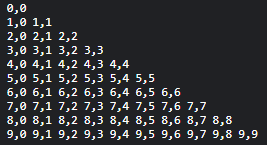

In [496]:
# Functions to compute the cost function

# Functions to map between cartesian coordinates and array indexes
def cartesian_to_array(x, y, shape):
    m, n = shape[:2]
    i = (n - 1) // 2 - y
    j = (n - 1) // 2 + x
    if i < 0 or i >= m or j < 0 or j >= n:
        raise ValueError("Coordinates not within given dimensions.")
    return i, j

# Cost of reconfiguring the robotic arm: the square root of the number of links rotated
def reconfiguration_cost(from_config, to_config):
    nlinks = len(from_config)
    diffs = np.abs(np.asarray(from_config) - np.asarray(to_config)).sum(axis=1)
    return np.sqrt(diffs.sum())

# Cost of moving from one color to another: the sum of the absolute change in color components
def color_cost(from_position, to_position, image, color_scale=3.0):
    return np.abs(image[to_position] - image[from_position]).sum() * color_scale


# Total cost of one step: the reconfiguration cost plus the color cost
def step_cost(from_config, to_config, image):
    from_position = cartesian_to_array(*get_position(from_config), image.shape)
    to_position   = cartesian_to_array(*get_position(to_config), image.shape)
    return (
        reconfiguration_cost(from_config, to_config) +
        color_cost(from_position, to_position, image)
    )

# Compute total cost of path over image
def total_cost(path, image):
    return reduce(
        lambda cost, pair: cost + step_cost(pair[0], pair[1], image),
        zip(path[:-1], path[1:]),
        0,
    )


def get_position(config):
    return reduce(lambda p, q: (p[0] + q[0], p[1] + q[1]), config, (0, 0))


In [475]:
def read_tour(filename):
    tour = []
    for line in open(filename).readlines():
        line = line.replace('\n', '')
        try:
            tour.append(int(line) - 1)
        except ValueError as e:
            pass  # skip if not a city id (int)
    return tour[:-1]

Write the specific edge weight for each image quadrant (.tsp files)

In [254]:
from tqdm.auto import tqdm

def write_tsp(df, df_q_dict, filename, name='santa-2022_q', fixed_point=None):
    
    fixed_point = df.index[-1] if fixed_point is None else fixed_point
    
    with open(filename, 'w') as f:
        f.write('NAME : %s\n' % name)
        f.write('COMMENT : %s\n' % name)
        f.write('TYPE : TSP\n')   #TSP
        f.write('DIMENSION : %d\n' % (len(df)))
        f.write('EDGE_WEIGHT_TYPE : EXPLICIT\n') # EXPLICIT/SPECIAL
        f.write('EDGE_WEIGHT_FORMAT : LOWER_DIAG_ROW\n') # Full matrix working
        f.write('FIXED_EDGES_SECTION\n')
        f.write('%d %d\n' % (fixed_point+1, 1))    # fixed travel between start and end points 
        f.write('%d\n' % (-1))
        f.write('EDGE_WEIGHT_SECTION\n')
        for i in tqdm(range(len(df))):
            line = tuple([cost_file(df_q_dict[i], df_q_dict[j], image) for j in range(i+1)])
            base = '%d '*(i) + '%d\n'
            f.write(base % line)
        #f.write('NODE_COORD_TYPE : TWOD_COORDS\n')
        #f.write('NODE_COORD_SECTION\n')
        #for row in df.itertuples():
        #    f.write('%d %d %d\n' % (row.Index + 1, row.x, row.y))
        #print(row.Index + 1, row.x, row.y)
        f.write('EOF\n')


write_tsp(df_q1, df_q1_dict_rev,
          filename='/kaggle/working/LKH-3.0.8/Pixels_Q1_v1.tsp', 
          name='santa-2022_q1')

write_tsp(df_q2, df_q2_dict_rev,
          filename='/kaggle/working/LKH-3.0.8/Pixels_Q2_v1.tsp', 
          name='santa-2022_q2')

write_tsp(df_q3, df_q3_dict_rev,
          filename='/kaggle/working/LKH-3.0.8/Pixels_Q3_v1.tsp', 
          name='santa-2022_q3')

write_tsp(df_q4, df_q4_dict_rev,
          filename='/kaggle/working/LKH-3.0.8/Pixels_Q4_v1.tsp', 
          name='santa-2022_q4', fixed_point = 8191)

  0%|          | 0/16512 [00:00<?, ?it/s]

  0%|          | 0/16512 [00:00<?, ?it/s]

  0%|          | 0/16512 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

In [255]:
!head -n 16 /kaggle/working/LKH-3.0.8/Pixels_Q4_v1.tsp

NAME : santa-2022_q4
COMMENT : santa-2022_q4
TYPE : TSP
DIMENSION : 16384
EDGE_WEIGHT_TYPE : EXPLICIT
EDGE_WEIGHT_FORMAT : LOWER_DIAG_ROW
FIXED_EDGES_SECTION
8192 1
-1
EDGE_WEIGHT_SECTION
0
230 0
1400 108 0
1400 1400 101 0
1400 1400 1400 100 0
1400 1400 1400 1400 101 0


In [ ]:
# initial tour, do not mandatory

with open('/kaggle/working/LKH-3.0.8/initial_tour_Q1.tour', 'w') as f:
    f.write('NAME : initial_tour_Q1.tour\n')
    f.write('TYPE : TOUR\n')
    f.write('DIMENSION : %d\n'%(len(r_q1_tour)))
    f.write('TOUR_SECTION\n')
    for node in r_q1_tour:
        f.write('%d\n' % (node+1)) # node count start with 1 instead 0
    f.write('%d\n' % (-1))

It is necessary to define the adequate LKH parameters to solve the TSP problem, the general image path solved per quadrant can be fully connected again if certain fixed edges were defined.

A representative parameter is `MOVE_TYPE`, it is set to 5-opt moves in this case. Each Quadrant can be solve with this in ~ 30 min.

In [477]:
def write_parameters(parameters, filename='/kaggle/working/LKH-3.0.8/params_Q1.par'):
    with open(filename, 'w') as f:
        for param, value in parameters:
            f.write("{} = {}\n".format(param, value))
    print("Parameters saved as", filename)

    
def generate_params(df=df_q1, quarter_section="Q1"):
    parameters = [
        ("PROBLEM_FILE", f"Pixels_{quarter_section}_v1.tsp"),
        ("OUTPUT_TOUR_FILE", f"tsp_solution_{quarter_section}.csv"),
        #("INITIAL_TOUR_FILE", "tsp_initial_Q1_v1.csv"),
        ("SEED", 2023),
        ("MOVE_TYPE","5"), #5 # 8-opt move
        ("RUNS","1"),
        ("KICKS","6"),
        #("MAX_CANDIDATES", 8),
        ("DEPOT", df.shape[0]//2),
        ('INITIAL_TOUR_ALGORITHM', 'GREEDY'), # BORUVKA | GREEDY |  NEAREST-NEIGHBOR | QUICK-BORUVKA | SIERPINSKI | WALK
        ('PATCHING_C', 5),
        ('PATCHING_A', 1),
        ('RECOMBINATION', 'GPX2'),

        ('CANDIDATE_SET_TYPE', 'NEAREST-NEIGHBOR'), #, 'POPMUSIC' 'NEAREST-NEIGHBOR', 'ALPHA' | DELAUNAY [ PURE ] QUADRANT
        #('ASCENT_CANDIDATES', '100'),
        ('TIME_LIMIT', 10000), #3600*5), # LIMIT in seconds
        ('PRECISION',10),
        ('INITIAL_PERIOD', 10000),
        ('MAX_TRIALS', 1000),
        ('TRACE_LEVEL', 1)
    ]

    write_parameters(parameters, filename=f'/kaggle/working/LKH-3.0.8/params_{quarter_section}.par')

generate_params(df=df_q1, quarter_section="Q1")
generate_params(df=df_q2, quarter_section="Q2")
generate_params(df=df_q3, quarter_section="Q3")
generate_params(df=df_q4, quarter_section="Q4")

Parameters saved as /kaggle/working/LKH-3.0.8/params_Q1.par
Parameters saved as /kaggle/working/LKH-3.0.8/params_Q2.par
Parameters saved as /kaggle/working/LKH-3.0.8/params_Q3.par
Parameters saved as /kaggle/working/LKH-3.0.8/params_Q4.par


In [257]:
!cat /kaggle/working/LKH-3.0.8/params_Q4.par

PROBLEM_FILE = Pixels_Q4_v1.tsp
OUTPUT_TOUR_FILE = tsp_solution_Q4.csv
SEED = 2023
MOVE_TYPE = 5
RUNS = 1
KICKS = 6
DEPOT = 8192
INITIAL_TOUR_ALGORITHM = GREEDY
PATCHING_C = 5
PATCHING_A = 1
RECOMBINATION = GPX2
CANDIDATE_SET_TYPE = NEAREST-NEIGHBOR
TIME_LIMIT = 10000
PRECISION = 10
INITIAL_PERIOD = 10000
MAX_TRIALS = 1000
TRACE_LEVEL = 1


In [258]:
%%time
%%bash -e
cd ./LKH-3.0.8
./LKH params_Q1.par

PARAMETER_FILE = params_Q1.par
Reading PROBLEM_FILE: "Pixels_Q1_v1.tsp" ... done
ASCENT_CANDIDATES = 50
BACKBONE_TRIALS = 0
BACKTRACKING = NO
# BWTSP =
# CANDIDATE_FILE =
CANDIDATE_SET_TYPE = NEAREST-NEIGHBOR
# DISTANCE =
# DEPOT =
# EDGE_FILE =
EXCESS = 6.0562e-05
EXTERNAL_SALESMEN = 0
EXTRA_CANDIDATES = 0 
EXTRA_CANDIDATE_SET_TYPE = QUADRANT
GAIN23 = YES
GAIN_CRITERION = YES
INITIAL_PERIOD = 10000
INITIAL_STEP_SIZE = 1
INITIAL_TOUR_ALGORITHM = GREEDY
# INITIAL_TOUR_FILE = 
INITIAL_TOUR_FRACTION = 1.000
# INPUT_TOUR_FILE = 
KICK_TYPE = 0
KICKS = 6
# MAX_BREADTH =
MAKESPAN = NO
MAX_CANDIDATES = 5 
MAX_SWAPS = 16512
MAX_TRIALS = 1000
# MERGE_TOUR_FILE =
MOVE_TYPE = 5 
# MTSP_MIN_SIZE =
# MTSP_MAX_SIZE =
# MTSP_OBJECTIVE =
# MTSP_SOLUTION_FILE = 
# NONSEQUENTIAL_MOVE_TYPE = 10
# OPTIMUM =
OUTPUT_TOUR_FILE = tsp_solution_Q1.csv
PATCHING_A = 1 
PATCHING_C = 5 
# PI_FILE = 
POPMUSIC_INITIAL_TOUR = NO
POPMUSIC_MAX_NEIGHBORS = 5
POPMUSIC_SAMPLE_SIZE = 10
POPMUSIC_SOLUTIONS = 50
POPMUSIC_TRIAL

In [259]:
%%time
%%bash -e
cd ./LKH-3.0.8
./LKH params_Q2.par

PARAMETER_FILE = params_Q2.par
Reading PROBLEM_FILE: "Pixels_Q2_v1.tsp" ... done
ASCENT_CANDIDATES = 50
BACKBONE_TRIALS = 0
BACKTRACKING = NO
# BWTSP =
# CANDIDATE_FILE =
CANDIDATE_SET_TYPE = NEAREST-NEIGHBOR
# DISTANCE =
# DEPOT =
# EDGE_FILE =
EXCESS = 6.0562e-05
EXTERNAL_SALESMEN = 0
EXTRA_CANDIDATES = 0 
EXTRA_CANDIDATE_SET_TYPE = QUADRANT
GAIN23 = YES
GAIN_CRITERION = YES
INITIAL_PERIOD = 10000
INITIAL_STEP_SIZE = 1
INITIAL_TOUR_ALGORITHM = GREEDY
# INITIAL_TOUR_FILE = 
INITIAL_TOUR_FRACTION = 1.000
# INPUT_TOUR_FILE = 
KICK_TYPE = 0
KICKS = 6
# MAX_BREADTH =
MAKESPAN = NO
MAX_CANDIDATES = 5 
MAX_SWAPS = 16512
MAX_TRIALS = 1000
# MERGE_TOUR_FILE =
MOVE_TYPE = 5 
# MTSP_MIN_SIZE =
# MTSP_MAX_SIZE =
# MTSP_OBJECTIVE =
# MTSP_SOLUTION_FILE = 
# NONSEQUENTIAL_MOVE_TYPE = 10
# OPTIMUM =
OUTPUT_TOUR_FILE = tsp_solution_Q2.csv
PATCHING_A = 1 
PATCHING_C = 5 
# PI_FILE = 
POPMUSIC_INITIAL_TOUR = NO
POPMUSIC_MAX_NEIGHBORS = 5
POPMUSIC_SAMPLE_SIZE = 10
POPMUSIC_SOLUTIONS = 50
POPMUSIC_TRIAL

In [260]:
%%time
%%bash -e
cd ./LKH-3.0.8
./LKH params_Q3.par

PARAMETER_FILE = params_Q3.par
Reading PROBLEM_FILE: "Pixels_Q3_v1.tsp" ... done
ASCENT_CANDIDATES = 50
BACKBONE_TRIALS = 0
BACKTRACKING = NO
# BWTSP =
# CANDIDATE_FILE =
CANDIDATE_SET_TYPE = NEAREST-NEIGHBOR
# DISTANCE =
# DEPOT =
# EDGE_FILE =
EXCESS = 6.0562e-05
EXTERNAL_SALESMEN = 0
EXTRA_CANDIDATES = 0 
EXTRA_CANDIDATE_SET_TYPE = QUADRANT
GAIN23 = YES
GAIN_CRITERION = YES
INITIAL_PERIOD = 10000
INITIAL_STEP_SIZE = 1
INITIAL_TOUR_ALGORITHM = GREEDY
# INITIAL_TOUR_FILE = 
INITIAL_TOUR_FRACTION = 1.000
# INPUT_TOUR_FILE = 
KICK_TYPE = 0
KICKS = 6
# MAX_BREADTH =
MAKESPAN = NO
MAX_CANDIDATES = 5 
MAX_SWAPS = 16512
MAX_TRIALS = 1000
# MERGE_TOUR_FILE =
MOVE_TYPE = 5 
# MTSP_MIN_SIZE =
# MTSP_MAX_SIZE =
# MTSP_OBJECTIVE =
# MTSP_SOLUTION_FILE = 
# NONSEQUENTIAL_MOVE_TYPE = 10
# OPTIMUM =
OUTPUT_TOUR_FILE = tsp_solution_Q3.csv
PATCHING_A = 1 
PATCHING_C = 5 
# PI_FILE = 
POPMUSIC_INITIAL_TOUR = NO
POPMUSIC_MAX_NEIGHBORS = 5
POPMUSIC_SAMPLE_SIZE = 10
POPMUSIC_SOLUTIONS = 50
POPMUSIC_TRIAL

In [261]:
%%time
%%bash -e
cd ./LKH-3.0.8
./LKH params_Q4.par

PARAMETER_FILE = params_Q4.par
Reading PROBLEM_FILE: "Pixels_Q4_v1.tsp" ... done
ASCENT_CANDIDATES = 50
BACKBONE_TRIALS = 0
BACKTRACKING = NO
# BWTSP =
# CANDIDATE_FILE =
CANDIDATE_SET_TYPE = NEAREST-NEIGHBOR
# DISTANCE =
# DEPOT =
# EDGE_FILE =
EXCESS = 6.10352e-05
EXTERNAL_SALESMEN = 0
EXTRA_CANDIDATES = 0 
EXTRA_CANDIDATE_SET_TYPE = QUADRANT
GAIN23 = YES
GAIN_CRITERION = YES
INITIAL_PERIOD = 10000
INITIAL_STEP_SIZE = 1
INITIAL_TOUR_ALGORITHM = GREEDY
# INITIAL_TOUR_FILE = 
INITIAL_TOUR_FRACTION = 1.000
# INPUT_TOUR_FILE = 
KICK_TYPE = 0
KICKS = 6
# MAX_BREADTH =
MAKESPAN = NO
MAX_CANDIDATES = 5 
MAX_SWAPS = 16384
MAX_TRIALS = 1000
# MERGE_TOUR_FILE =
MOVE_TYPE = 5 
# MTSP_MIN_SIZE =
# MTSP_MAX_SIZE =
# MTSP_OBJECTIVE =
# MTSP_SOLUTION_FILE = 
# NONSEQUENTIAL_MOVE_TYPE = 10
# OPTIMUM =
OUTPUT_TOUR_FILE = tsp_solution_Q4.csv
PATCHING_A = 1 
PATCHING_C = 5 
# PI_FILE = 
POPMUSIC_INITIAL_TOUR = NO
POPMUSIC_MAX_NEIGHBORS = 5
POPMUSIC_SAMPLE_SIZE = 10
POPMUSIC_SOLUTIONS = 50
POPMUSIC_TRIA

In [491]:
# auxiliar function to read tsp huristic solution
def gen_tour(df=df_q1, tour_file='../working/LKH-3.0.8/tsp_solution_Q1.csv', order=-1, extra=-1, name='Q1'):
    tour = read_tour(tour_file)
    tour = np.roll(tour, -tour.index(0)+extra)[::order]
    #tour = list(np.roll(tour, len(tour)-tour.index(df_q1.shape[0]-1)-1))#[::-1]
    t_points = [tuple(el) for el in df.loc[tour][['x','y']].to_numpy()]
    
    #tour[-1], tour[0]
    print(f"Tour length {name} {len(tour)} ", end='')
    print(f"Init / Final: {t_points[0]}, {t_points[-1]}")
    return t_points

In [492]:
t_points_q1 = gen_tour(df=df_q1, tour_file='../working/LKH-3.0.8/tsp_solution_Q1.csv', name='Q1')
t_points_q2 = gen_tour(df=df_q2, tour_file='../working/LKH-3.0.8/tsp_solution_Q2.csv', name='Q2')
t_points_q3 = gen_tour(df=df_q3, tour_file='../working/LKH-3.0.8/tsp_solution_Q3.csv',order=-1, extra=-1, name='Q3')
t_points_q4 = gen_tour(df=df_q4, tour_file='../working/LKH-3.0.8/tsp_solution_Q4.csv', order=1, extra=0, name='Q4')

Tour length Q1 16512 Init / Final: (1, 128), (128, 0)
Tour length Q2 16512 Init / Final: (128, -1), (0, -128)
Tour length Q3 16512 Init / Final: (-1, -128), (-128, 0)
Tour length Q4 16384 Init / Final: (-128, 1), (-1, 64)


In [498]:
#### search config provided functions

def rotate(config, i, direction):
    config = config.copy()
    config[i] = rotate_link(config[i], direction)
    return config

def get_direction(u, v):
    """Returns the sign of the angle from u to v."""
    direction = np.sign(np.cross(u, v))
    if direction == 0 and np.dot(u, v) < 0:
        direction = 1
    return direction

def rotate_link(vector, direction):
    x, y = vector
    if direction == 1:  # counter-clockwise
        if y >= x and y > -x:
            x -= 1
        elif y > x and y <= -x:
            y -= 1
        elif y <= x and y < -x:
            x += 1
        else:
            y += 1
    elif direction == -1:  # clockwise
        if y > x and y >= -x:
            x += 1
        elif y >= x and y < -x:
            y += 1
        elif y < x and y <= -x:
            x -= 1
        else:
            y -= 1
    return (x, y)

# compress a path between two points
def compress_path(path):
    r = [[] for _ in range(8)]
    for p in path:
        for i in range(8):
            if len(r[i]) == 0 or r[i][-1] != p[i]:
                r[i].append(p[i])
    mx = max([len(x) for x in r])
    
    for rr in r:
        while len(rr) < mx:
            rr.append(rr[-1])
    r = list(zip(*r))
    for i in range(len(r)):
        r[i] = list(r[i])
    return r


def get_path_to_point(config, point):
    """Find a path of configurations to `point` starting at `config`."""
    path = [config]
    # Rotate each link, starting with the largest, until the point can
    # be reached by the remaining links. The last link must reach the
    # point itself.
    for i in range(len(config)):
        link = config[i]
        base = get_position(config[:i])
        relbase = (point[0] - base[0], point[1] - base[1])
        position = get_position(config[:i+1])
        relpos = (point[0] - position[0], point[1] - position[1])
        radius = reduce(lambda r, link: r + max(abs(link[0]), abs(link[1])), config[i+1:], 0)
        # Special case when next-to-last link lands on point. 
        if radius == 1 and relpos == (0, 0):
            config = rotate(config, i, 1)
            if get_position(config) == point:
                path.append(config)
                break
            else:
                continue
        while np.max(np.abs(relpos)) > radius:
            direction = get_direction(link, relbase)
            config = rotate(config, i, direction)
            path.append(config)
            link = config[i]
            base = get_position(config[:i])
            relbase = (point[0] - base[0], point[1] - base[1])
            position = get_position(config[:i+1])
            relpos = (point[0] - position[0], point[1] - position[1])
            radius = reduce(lambda r, link: r + max(abs(link[0]), abs(link[1])), config[i+1:], 0)
    assert get_position(path[-1]) == point
    path_n = compress_path(path)
    return path_n

def get_path_to_configuration(from_config, to_config):
    path = [from_config]
    config = from_config.copy()
    while config != to_config:
        for i in range(len(config)):
            config = rotate(config, i, get_direction(config[i], to_config[i]))
        path.append(config)
    assert path[-1] == to_config
    return path

In [499]:
# search for config given the path of points
def gen_point_config(x,y, pre_config=''):
    
    origin = [(64, 0), (-32, 0), (-16, 0), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)]
    #path   = [origin]
    
    if x==0 and y==0:
        return origin
    
    elif x==0 and y>0:
        #for i in range(1,y+1):
        t_path = get_path_to_point(pre_config, (0,y))
        #path.extend(t_path[-1:])
        return t_path[1:]
    else:
        return prefer_config(x,y)

In [500]:
# soluion per quadrant connected
tsp_path = t_points_q1+t_points_q2+t_points_q3+t_points_q4

# init configurations to avoid overlapping as much as possible
t_config  = [(64, 0), (-32, 32), (-16, 16), (-8, 8), (-4, 4), (-2, 2), (-1, 1), (-1, 1)] # (0,64)
init_path = get_path_to_configuration(gen_point_config(0,0), t_config)

#### define path by points
path = [(0,i) for i in range(65,129)]
total_path = path + tsp_path

#################################### retrive configurations according established constrains
total_path_config = [init_path[-1]]
for (t_x,t_y) in tqdm(total_path):
    t_config = gen_point_config(t_x,t_y, total_path_config[-1])
    
    if t_x==0 and t_y>0:
        total_path_config += t_config
    else:
        total_path_config.append(t_config)
####################################

total_path_config = init_path + total_path_config[1:]

## return to origin
return_to_origin = get_path_to_configuration(total_path_config[-1], gen_point_config(0,0))[1:]
total_path_config  +=  return_to_origin

  0%|          | 0/65984 [00:00<?, ?it/s]

Validate path configuration

In [501]:
def check_integrity_config(config1, config2):
    t1 = np.array(config1)
    t2 = np.array(config2)
    return np.max(np.abs(t1 - t2), axis=1).max()

if max([check_integrity_config(config1, config2) for config1, config2 in zip(total_path_config[:-1], total_path_config[1:])]) == 1:
    print("The path is valid.")

The path is valid.


# <p style="font-family:Helvetica; font-weight:bold; letter-spacing: 0px; color:#cc1818; font-size:100%; text-align:left;padding: 5px; border-bottom: 5px solid #cc1818">Final Optimized Path</p>

Extra steps 33


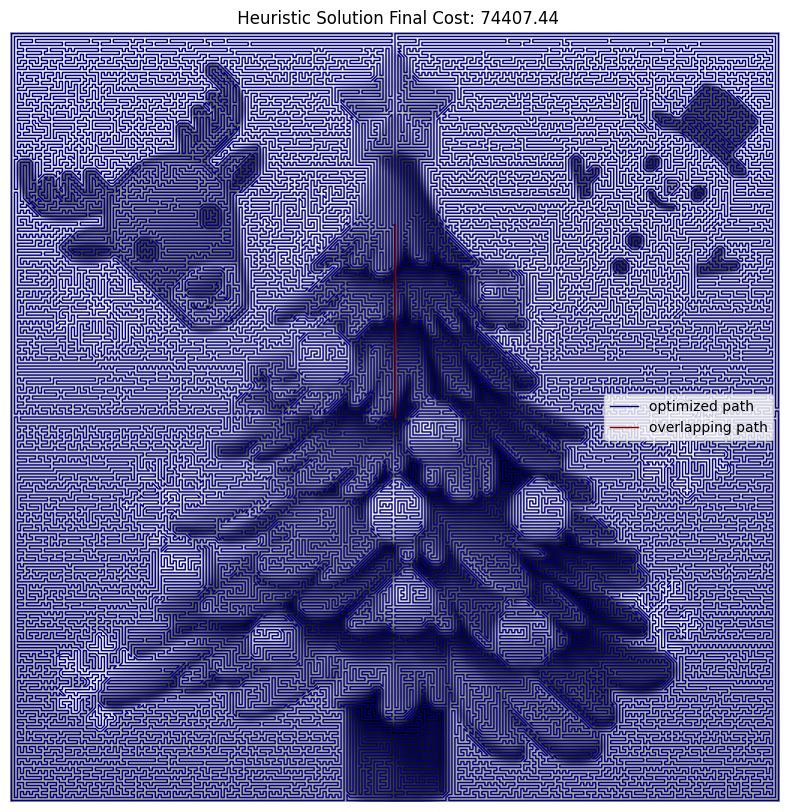

In [506]:
r_points = [get_position(el) for el in total_path_config]
n_points = [get_position(el) for el in return_to_origin]

x,y = list(zip(*r_points))
x_n,y_n = list(zip(*n_points))

gray = np.mean(image, -1)
f,ax=plt.subplots(figsize=(10,10))

ax.plot(x,y, lw=1, color="navy", label="optimized path")
ax.plot(x_n,y_n, lw=1, color="darkred", label="overlapping path")
#ax.plot(x[:7000], y[:7000], lw=1, color="darkred")
ax.legend()

ax.set_title(f" Heuristic Solution Final Cost: {total_cost(path=total_path_config, image=image):.2f}")
ax.imshow(gray, extent=[-128.5,128.5,-128.5,128.5], cmap='gray')
ax.axis("off")

print(f"Extra steps {len(total_path_config)- 257*257}")

# Final Considerations

- The heuristic solution found can be further optimized by reviewing the paths of the connectors between quadrants and the overlap path nnecessary to return to the initial configuration of the arm.
- A general problem instead of image quadrant subproblems may be more efficent.
- The LKH algorithm can be effectively used to solve any TPS problem with proper parameters.